In [1]:
import tensorflow as tf

In [2]:
import warnings; warnings.simplefilter('ignore')

In [3]:
import os
import sys
import math
import random
import numpy as np
import cv2
#import Mask
import skimage.io
#from IPython.display import Image
from PIL import Image
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt




# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.visualize import display_images


%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [4]:
class CellsConfig(Config):
    NAME = "cells"
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    
    NUM_CLASSES = 1+1 # background + cell
    
    # size of images are 256px X 256px
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 1024 
    
     # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    #TRAIN_ROIS_PER_IMAGE = 512
    TRAIN_ROIS_PER_IMAGE = 200
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 50
    
    LEARNING_RATE = 1e-4 

config = CellsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'rpn_bbox_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INST

In [5]:
class CellsDataset(utils.Dataset):
    """Generates a cells dataset for training. Dataset consists of microscope images
    of one cell and a background. They each have a 256x256 resolution"""
        
    def load_cells(self, dataset_dir, subset):
        """Loads cell images from the dataset directory"""
        
        # Add class
        self.add_class("cells", 1, "cellobj")
 
        assert subset in ["train", "test", "fov"]
        if subset=="train":
            dataset_dir = os.path.join(dataset_dir, "training_data")
        elif subset=="test":
            dataset_dir = os.path.join(dataset_dir, "testing_data")
        elif subset=="fov":
            pass
        count = 0
        for image_dir in next(os.walk(dataset_dir))[1]:
            path = os.path.join(dataset_dir, os.path.join(image_dir, 'image/image.tif'))
            self.add_image('cells', count, path)
            count +=1
    
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If 16bit, convert to 8bit
        if image.dtype=='uint16': 
            image = self.map_uint16_to_uint8(image, lower_bound=None, upper_bound=None)
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image
    
    
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        
        # Get mask directory from image path
        mask_dir = os.path.join(os.path.dirname(os.path.dirname(info['path'])), "masks")
        print(mask_dir)
        # Read mask files from .jpg image
        mask = []
        for f in next(os.walk(mask_dir))[2]:
            if f.endswith('.tif'):
                m = skimage.io.imread(os.path.join(mask_dir, f)).astype(np.bool)
                mask.append(m)
        mask = np.stack(mask, axis=-1)
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID, we return an array of ones
        return mask, np.ones([mask.shape[-1]], dtype=np.int32) 
    
    def map_uint16_to_uint8(self, img, lower_bound=None, upper_bound=None):
        '''
        Map a 16-bit image trough a lookup table to convert it to 8-bit.

        Parameters
        ----------
        img: numpy.ndarray[np.uint16]
            image that should be mapped
        lower_bound: int, optional
            lower bound of the range that should be mapped to ``[0, 255]``,
            value must be in the range ``[0, 65535]`` and smaller than `upper_bound`
            (defaults to ``numpy.min(img)``)
        upper_bound: int, optional
           upper bound of the range that should be mapped to ``[0, 255]``,
           value must be in the range ``[0, 65535]`` and larger than `lower_bound`
           (defaults to ``numpy.max(img)``)

        Returns
        -------
        numpy.ndarray[uint8]
        '''
        
        if lower_bound is None:
            lower_bound = np.min(img)
        if not(0 <= lower_bound < 2**16):
            raise ValueError(
                '"lower_bound" must be in the range [0, 65535]')
        if upper_bound is None:
            upper_bound = np.max(img)
        if not(0 <= upper_bound < 2**16):
            raise ValueError(
                '"upper_bound" must be in the range [0, 65535]')    
        if lower_bound >= upper_bound:
            raise ValueError(
                '"lower_bound" must be smaller than "upper_bound"')
        lut = np.concatenate([
            np.zeros(lower_bound, dtype=np.uint16),
            np.linspace(0, 255, upper_bound - lower_bound).astype(np.uint16),
            np.ones(2**16 - upper_bound, dtype=np.uint16) * 255
        ])
        return lut[img].astype(np.uint8)
        
    def pad(self, num):
        return '{0:04d}'.format(num)
    
    def size(self):
        return len(self._image_ids)

    

In [6]:
dataset_dir = os.path.join(ROOT_DIR, '/data/kimjb/Mask_RCNN/images/images')


dataset_train = CellsDataset()
dataset_train.load_cells(dataset_dir, subset="train")
dataset_train.prepare()

dataset_test = CellsDataset()
dataset_test.load_cells(dataset_dir, subset="test")
dataset_test.prepare()



### Image visualization

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    print(image.shape)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=1)

In [ ]:
# Load random image and mask.
image_id = random.choice(dataset_train.image_ids)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_train.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

In [ ]:
#image_id = np.random.choice(dataset.image_ids, 1)[0]
#image_id = random.choice(dataset_train.image_ids)
info = dataset_train.image_info[image_id]
print(info['path'])
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset_train, config, image_id, use_mini_mask=False)

visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=1)
log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(mask.shape[-1])])

In [ ]:
augmentation = iaa.Sometimes(0.9, [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Multiply((0.8, 1.2)),
    iaa.GaussianBlur(sigma=(0.0, 5.0))
])

In [ ]:
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset_train, config, image_id, augmentation=augmentation, use_mini_mask=True)
print(mask.shape)
display_images([image]+[mask[:,:,i] for i in range(mask.shape[-1])])

In [ ]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

### Inference (testing with and without GT)

In [7]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

In [11]:
class InferenceConfig(CellsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # below, comment if running inference on small crops
    #TRAIN_ROIS_PER_IMAGE = 2000
    POST_NMS_ROIS_INFERENCE = 13000
    DETECTION_MAX_INSTANCES = 200
    DETECTION_NMS_THRESHOLD = 0.35

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")

model_path = model.find_last()[1]
# model_path = '/data/kimjb/Mask_RCNN/logs/cells20180628T1527/mask_rcnn_cells_0100.h5'

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  None


TypeError: expected str, bytes or os.PathLike object, not NoneType

In [ ]:
# prints the mAP for the specific model

def get_ap_for_model(model_path):
    
    model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)
    
    assert model_path != "", "Provide path to trained weights"
    model.load_weights(model_path, by_name=True)
    
    image_ids = np.random.choice(dataset_test.image_ids, 15)
    APs = []
    for image_id in image_ids:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_test, inference_config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        # Run objebct detection
        results = model.detect([image], verbose=0)
        r = results[0]
        # Compute AP
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)
    
    meanAP = np.mean(APs)
    
    #print("mAP: {mean} \nmodel: {path} \n".format(mean=np.mean(APs), path=model_path))
    return meanAP

In [ ]:
# go through each model in model_dir
model_dir = '/data/kimjb/Mask_RCNN/logs/cells20180626T1146/'
epoch_ap_dict = {}
epoch_check_list = []

for filename in os.listdir(model_dir):
    if filename.endswith('.h5'): 
        epoch_check_list.append(filename)

epoch_check_list.sort()

# get model for 
for model in epoch_check_list[24::25]:
    model_path = os.path.join(model_dir, model)
    mAP = get_ap_for_model(model_path)
    epoch_ap_dict[filename] = mAP
                
for key in sorted(epoch_ap_dict.keys()):
    print("mAP: {mean} \nmodel: {path} \n".format(mean=epoch_ap_dict[key], path=key))

In [ ]:
for key in sorted(epoch_ap_dict.keys()):
    print("mAP: {mean} \nmodel: {path} \n".format(mean=epoch_ap_dict[key], path=key))

In [ ]:
get_ap_for_model('/data/kimjb/Mask_RCNN/logs/cells20180626T1146/mask_rcnn_cells_0100.h5')

In [ ]:
image_id = random.choice(dataset_test.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)


In [ ]:
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names)

In [ ]:
SEaug = iaa.Sequential( [
    iaa.Sharpen(alpha=(0.0, 1.0), lightness=(0.75, 2.0)),
    iaa.Emboss(alpha=(0.0, 1.0), strength=(0.5, 1.5))
], random_order=True)

# Gaussian Noise
GNaug = iaa.AdditiveGaussianNoise(scale=(0, 0.05*255))

# Color
Caug = iaa.Sequential([
    iaa.WithChannels(0, iaa.Add((10, 100))),
    iaa.WithChannels(1, iaa.Add((10, 100))),
    iaa.WithChannels(2, iaa.Add((10, 100)))
])

# Brightness and Contrast
BCaug = iaa.Sequential([
    iaa.ContrastNormalization((0.5, 1.5)),
    iaa.Multiply((0.5, 1.5))
], random_order=True)

# Flips
Faug = iaa.Sequential( [
    iaa.Fliplr(.5),
    iaa.Flipud(.5),
])

#blur and brightness - intuition is that some cells are super bright and blurred so this will help identify cells like that
BBaug = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0.0, 3.0)),
    iaa.AverageBlur(k=(2, 5)),
    iaa.MedianBlur(k=(3, 7)),
    iaa.Multiply((.5, 3))
], random_order=True)

Taug = iaa.Sequential( [
    iaa.ElasticTransformation(alpha=(0, 5.0), sigma=0.25),
    iaa.Superpixels(p_replace=0.5, n_segments=64),
    iaa.PiecewiseAffine(scale=(0.01, 0.05))
])

augmentation = iaa.Sometimes(.5, [
        SEaug,
        GNaug,
        Caug,
        BBaug,
        BCaug,
        Faug,
        Taug
    ])

In [ ]:
# transformations
Taug = iaa.Sequential( [
    iaa.ElasticTransformation(alpha=(0, 2.0), sigma=0.25),
    iaa.Superpixels(p_replace=0.5, n_segments=64),
    iaa.PiecewiseAffine(scale=(0.01, 0.05))
])
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset_train, config, image_id, augmentation=Taug, use_mini_mask=False)
display_images([image])

In [ ]:
image_id = random.choice(dataset_test.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, config, image_id, use_mini_mask=False)
info = dataset_train.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_train.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset_train.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)

In [9]:
dataset_dir = '/data/kimjb/Mask_RCNN/images/fov'

fov_dataset = CellsDataset()
fov_dataset.load_cells(dataset_dir, subset='fov')
fov_dataset.prepare()


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


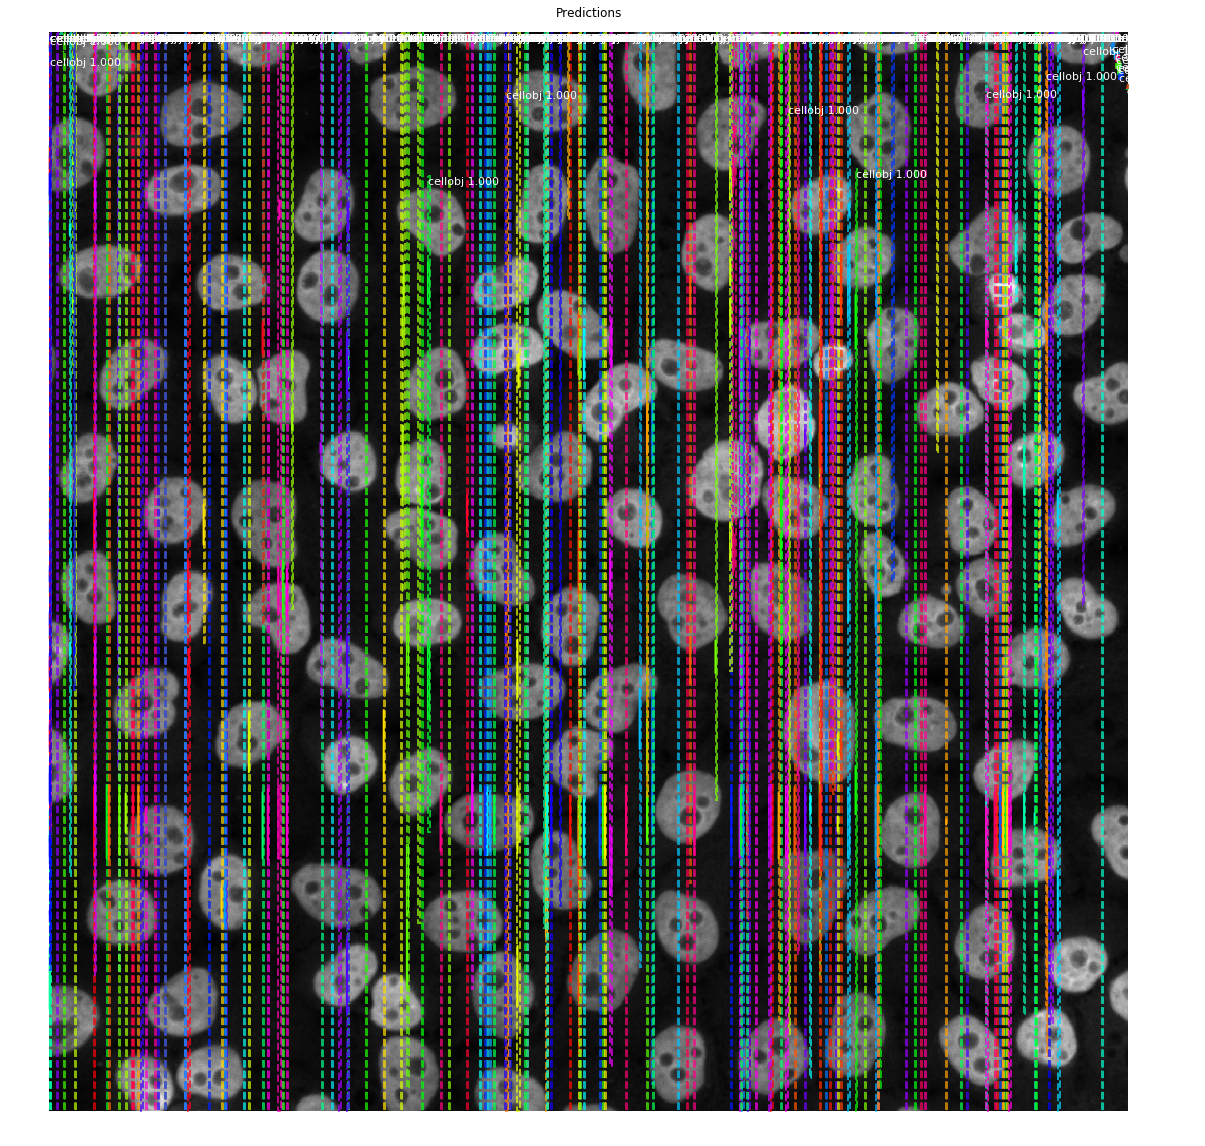

In [10]:
# Run object detection
image_id = random.choice(fov_dataset.image_ids)
image = fov_dataset.load_image(image_id)
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            fov_dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

In [ ]:
flipud = np.flipud(image)
udresults = model.detect([flipud], verbose=1)
ax = get_ax(1)
udr = udresults[0]
visualize.display_instances(flipud, udr['rois'], udr['masks'], udr['class_ids'], 
                            fov_dataset.class_names, udr['scores'], ax=ax,
                            title="Predictions")

In [ ]:
fliplr = np.fliplr(image)
lrresults = model.detect([fliplr], verbose=1)
ax = get_ax(1)
lrr = lrresults[0]
visualize.display_instances(fliplr, lrr['rois'], lrr['masks'], lrr['class_ids'], 
                            fov_dataset.class_names, lrr['scores'], ax=ax,
                            title="Predictions")

In [ ]:
def randomCrop(img, width, height):
    assert img.shape[0] >= height
    assert img.shape[1] >= width
    x = random.randint(0, img.shape[1] - width)
    y = random.randint(0, img.shape[0] - height)
    img = img[y:y+height, x:x+width]
    return img

cimage = randomCrop(fov_dataset.load_image(image_id), 256, 256)
cresults = model.detect([cimage], verbose=1)

# Display results
ax = get_ax(1)
cr = cresults[0]
visualize.display_instances(cimage, cr['rois'], cr['masks'], cr['class_ids'], 
                            fov_dataset.class_names, cr['scores'], ax=ax,
                            title="Predictions")

In [ ]:
# split into 4 blocks
print(image.shape)
b1 = image[0:512, 0:512,:]

b1results = model.detect([b1], verbose=1)
ax = get_ax(1)
b1r = b1results[0]
visualize.display_instances(b1, b1r['rois'], b1r['masks'], b1r['class_ids'], 
                            fov_dataset.class_names, b1r['scores'], ax=ax,
                            title="Predictions")

In [ ]:
b2 = image[0:512, 512:,:]

b2results = model.detect([b2], verbose=1)
ax = get_ax(1)
b2r = b2results[0]
visualize.display_instances(b2, b2r['rois'], b2r['masks'], b2r['class_ids'], 
                            fov_dataset.class_names, b2r['scores'], ax=ax,
                            title="Predictions")

In [ ]:
b3 = image[512:, 0:512,:]

b3results = model.detect([b3], verbose=1)
ax = get_ax(1)
b3r = b3results[0]
visualize.display_instances(b3, b3r['rois'], b3r['masks'], b3r['class_ids'], 
                            fov_dataset.class_names, b3r['scores'], ax=ax,
                            title="Predictions")

In [ ]:
b4 = image[512:, 512:,:]

b4results = model.detect([b4], verbose=1)
ax = get_ax(1)
b4r = b4results[0]
visualize.display_instances(b4, b4r['rois'], b4r['masks'], b4r['class_ids'], 
                            fov_dataset.class_names, b4r['scores'], ax=ax,
                            title="Predictions")

In [ ]:
print(type(model.keras_model))
# serialize model to JSON
model_json = model.keras_model.to_json()
with open("/scratch/kimjb/to-zakigf/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
#model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
model.find_last()[1]
model.find_last()[0]